In [1]:
import numpy as np
import cv2
import scipy
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
import operator


In [2]:
tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

# Origin | Destination | Origin City | Desination City | Passengers | Seats | Flights | Distance | Fly Date | Origin Population | Destination Population
#   0	 |		1 	   |	  2		 |		  3		   | 	 4		|	5	| 	 6	  |		7	 |	  8		|		  9			|		    10
data_len = 0
total_city=set()
pop_all_city= dict()
for row in tsvin:
    total_city.add(row[2])
    total_city.add(row[3])

    if(row[2],row[3]) in pop_all_city:
        pop_all_city[(row[2],row[3])]+= int(row[6])
    elif (row[3],row[2]) in pop_all_city:
        pop_all_city[(row[3],row[2])]+= int(row[6])
    else:
        pop_all_city[(row[2],row[3])]= int(row[6])
    data_len+=1
total_city = list(total_city)
pop_all_city_list = sorted(pop_all_city.items(), key=operator.itemgetter(1))
pop_all_city_list.reverse()


In [3]:
# Take out only flight dest. orig. with >=1000 flights
sub_pop_city = dict()
for key in pop_all_city:
    if(pop_all_city[key]>=1000):
        sub_pop_city[key]=pop_all_city[key]
sub_pop_lst = sorted(sub_pop_city.items(), key=operator.itemgetter(1))
sub_pop_lst.reverse()



sub_city_set = set()
for datum in sub_pop_lst:
    sub_city_set.add(datum[0][0])
    sub_city_set.add(datum[0][1])
sub_city_lst=list(sub_city_set)

In [4]:
sub_data=[]
tsvin_f.seek(0)
for row in tsvin:
    if((row[2],row[3]) in sub_pop_city) or ((row[3],row[2]) in sub_pop_city):
        sub_data.append(row)


In [5]:
print("total_city",len(total_city))
print("pop_all_city",len(pop_all_city))
print("sub_data",len(sub_data))
print("sub_city_set",len(sub_city_set))
print(data_len)
print(sub_city_lst)

('total_city', 563)
('pop_all_city', 18869)
('sub_data', 3421585)
('sub_city_set', 358)
3606803
['Rapid City, SD', 'Fort Wayne, IN', 'South Bend, IN', 'Bend, OR', 'Scottsbluff, NE', 'Kodiak, AK', 'Grand Island, NE', 'Oshkosh, WI', 'Great Falls, MT', 'Oxnard, CA', 'Fort Lauderdale, FL', 'Reading, PA', 'Moses Lake, WA', 'Jamestown, NY', 'Elmira, NY', 'Spokane, WA', 'Cumberland, MD', 'Bellingham, WA', 'Dodge City, KS', 'Bakersfield, CA', 'Gainesville, FL', 'Hartford, CT', 'Vernal, UT', 'Athens, GA', 'Jamestown, ND', 'Lawton, OK', 'San Antonio, TX', 'St. Cloud, MN', 'Worcester, MA', 'Dothan, AL', 'Corpus Christi, TX', 'Stockton, CA', 'Huntsville, AL', 'Brookings, SD', 'Lewiston, ID', 'Mobile, AL', 'Hattiesburg, MS', 'Rockland, ME', 'Memphis, TN', 'Ketchikan, AK', 'Alexandria, LA', 'Lansing, MI', 'Burlington, VT', 'Kearney, NE', 'El Centro, CA', 'Jackson, MS', 'Chico, CA', 'Aberdeen, SD', 'Flagstaff, AZ', 'La Crosse, WI', 'Huron, SD', 'Missoula, MT', 'Indianapolis, IN', 'Lake Charles, LA', 

In [6]:
data_size = len(sub_data)
city_size = len(sub_city_set)

counter = 0
offset 	= city_size
y		= np.zeros(data_size)
feature = np.zeros((data_size, (city_size+5) ))

# For prediction
real_occp= np.zeros((10,12))
real_occp_count = np.zeros((10,12))
dist=np.zeros((10,2))
pop_a=np.zeros((10,2))
pop_b=np.zeros((10,2))
flight=np.zeros((10,12,2))
# Origin | Destination | Origin City | Desination City | Passengers | Seats | Flights | Distance | Fly Date | Origin Population | Destination Population
#   0	 |		1 	   |	  2		 |		  3		   | 	 4		|	5	| 	 6	  |		7	 |	  8		|		  9			|		    10
print("Parsing Data")
for row in sub_data:
    if(row[5]=='0'):
        continue
    dest = sub_city_lst.index(row[2])
    orig = sub_city_lst.index(row[3])
    feature[counter,dest]=1.0
    feature[counter,orig]=1.0
    feature[counter,offset]=float(row[7])
    feature[counter,offset+1]=float(row[9])
    feature[counter,offset+2]=float(row[10])
    feature[counter,offset+3]=float(row[8][4:6])
    feature[counter,offset+4]=float(row[6])
#     feature[counter,offset+5]=1.0
    # feature[counter,offset+6]=float(row[8][0:4])-1990
    y[counter]=float(row[4])/float(row[5])*100
    counter +=1

#   Getting data for most popular flights too
    for i in range(10):
        if(row[2],row[3]) == sub_pop_lst[i][0]:
            real_occp_count[i,int(row[8][4:6])-1]+= 1
            real_occp[i,int(row[8][4:6])-1]+= float(row[4])/float(row[5])*100

            dist[i,0]	+=float(row[7])
            pop_a[i,0]	+=float(row[9])
            pop_b[i,0]	+=float(row[10])
            flight[i,int(row[8][4:6])-1,0] += float(row[6])

            dist[i,1]	+=1
            pop_a[i,1]	+=1
            pop_b[i,1]	+=1
            flight[i,int(row[8][4:6])-1,1] += 1

        elif (row[3],row[2]) == sub_pop_lst[i][0]:
            real_occp_count[i,int(row[8][4:6])-1]+= 1
            real_occp[i,int(row[8][4:6])-1]+= float(row[4])/float(row[5])*100

            dist[i,0]	+=float(row[7])
            pop_a[i,0]	+=float(row[10])
            pop_b[i,0]	+=float(row[9])
            flight[i,int(row[8][4:6])-1,0] += float(row[6])

            dist[i,1]	+=1
            pop_a[i,1]	+=1
            pop_b[i,1]	+=1
            flight[i,int(row[8][4:6])-1,1] += 1

Parsing Data


In [7]:

# Quadratic at the 7 last feature
model = Ridge()
model2 = PolynomialFeatures(degree=12)
const_feat = np.ones((data_size,1))
extended = model2.fit_transform(feature[:,offset+3:])

print(feature.shape)
feature = np.concatenate( (feature[:,:offset+3], extended,const_feat), axis=1)
print(feature.shape)



(3421585L, 363L)
(3421585L, 453L)


In [8]:
print("Training Model")
split = int(len(feature)*0.8)
train_y	   	= y[:]
train_feat 	= feature[:,:]
# test_y		= y[split:]
# test_feat 	= feature[split:,:]
model.fit(train_feat, train_y)

Training Model


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [9]:
occp 	    = real_occp/real_occp_count
avg_dist 	=dist[:,0]/dist[:,1]
avg_pop_a	=pop_a[:,0]/pop_a[:,1]
avg_pop_b	=pop_b[:,0]/pop_b[:,1]
avg_flight 	=flight[:,:,0]/flight[:,:,1]
print(avg_dist.shape)
print(avg_pop_a.shape)
print(avg_pop_b.shape)
print(avg_flight.shape)
# print("Extending features")
# Regualar linear
# model = linear_model.LinearRegression(copy_X=False)

print("Testing Model")
total_lost = 0.0
predict = model.predict(train_feat)

for i in range(len(train_y)):
	total_lost += np.absolute(train_y[i]-predict[i])
average_lost = total_lost/float(len(train_y))
print("Average Lost: "+str(average_lost))

# Origin | Destination | Origin City | Desination City | Passengers | Seats | Flights | Distance | Fly Date | Origin Population | Destination Population
#   0	 |		1 	   |	  2		 |		  3		   | 	 4		|	5	| 	 6	  |		7	 |	  8		|		  9			|		    10



(10L,)
(10L,)
(10L,)
(10L, 12L)
Testing Model
Average Lost: 13.3234959609


Generating Predictions


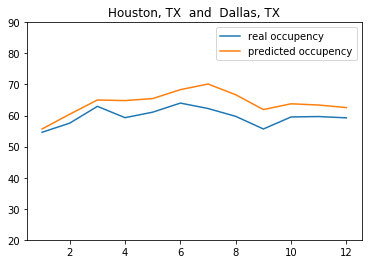

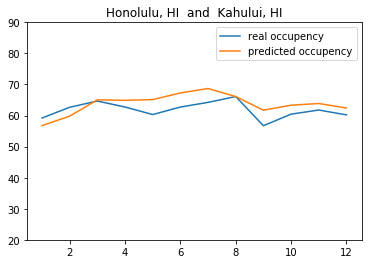

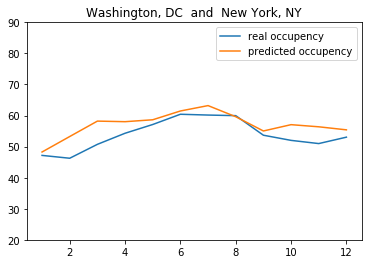

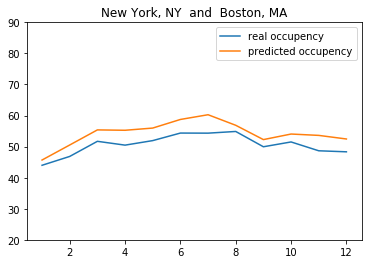

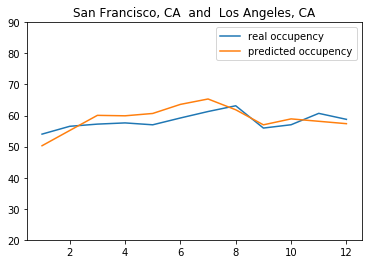

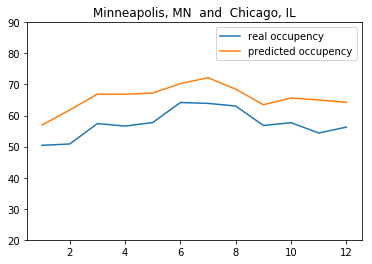

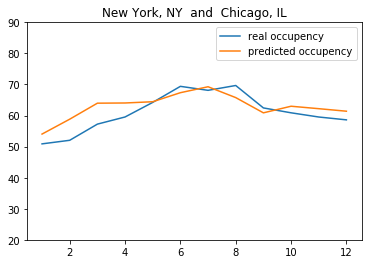

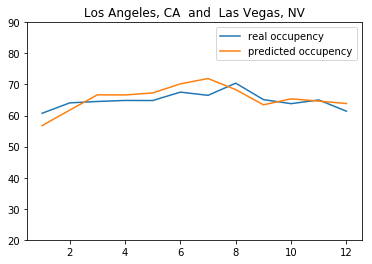

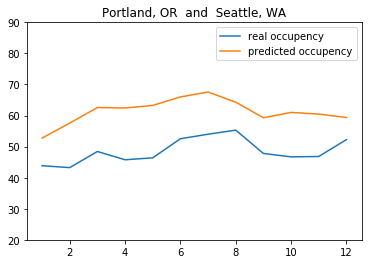

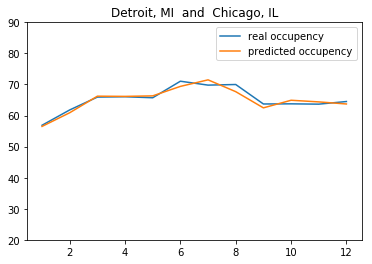

In [18]:
print("Generating Predictions")
for j in range(10):
    dest = sub_city_lst.index(sub_pop_lst[j][0][0])
    orig = sub_city_lst.index(sub_pop_lst[j][0][1])
    predict_feat = np.zeros((1,city_size+5))
    predict_feat[0,dest]=1.0
    predict_feat[0,orig]=1.0
    predict_feat[0,offset]=avg_dist[j]
    predict_feat[0,offset+1]=avg_pop_a[j]
    predict_feat[0,offset+2]=avg_pop_b[j]
    
    predict =[]
    for i in range(1,13):
        
        predict_feat[0,offset+3]=float(i)
        predict_feat[0,offset+4]=avg_flight[j,i-1]
        
        const_feat = np.ones((1,1))
        extended = model2.fit_transform(predict_feat[:,offset+3:])
        ext_feature = np.concatenate( (predict_feat[:,:offset+3],extended,const_feat), axis=1)
        
        predict.append(model.predict(ext_feature))
    pyplot.figure()
    pyplot.title(sub_pop_lst[j][0][0]+"  and  "+sub_pop_lst[j][0][1])
    pyplot.plot(range(1,13),occp[j,:], label="real occupency")
    pyplot.plot(range(1,13),predict, label="predicted occupency")
    pyplot.ylim((20,90))
    pyplot.legend()
    pyplot.show()